In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms



In [ ]:
#1. load the data
bs = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 252521903.55it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38937863.65it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 87215044.66it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19262415.34it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
images, lebels = next(iter(train_loader))

In [ ]:
images.max()

tensor(1.)

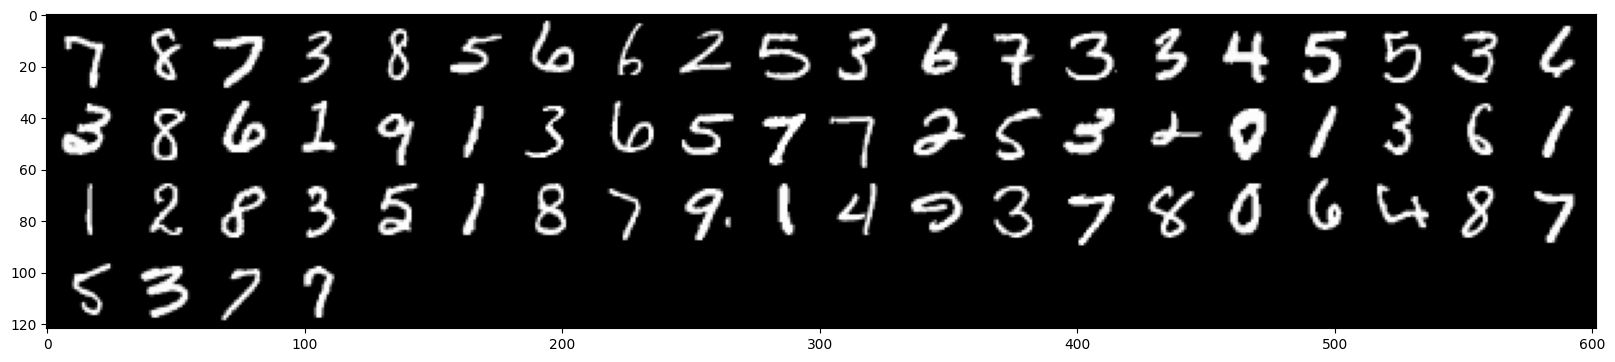

In [ ]:
#2. visiualize the data
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=20).permute(1,2,0).detach());


In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

In [ ]:
labels.shape

torch.Size([64])

In [ ]:
#for batch_idx, (data, y) in enumerate(train_loader):


In [ ]:
#Class VAE():
"""
Contient une methode encoder() => mu, sigma = NeuralNetwork(x, y) (x' = torch.concatenate(x, y) et après mu, sigma = NN(x'));
Contient une méthode decoder() => mu, sigma = NeuralNetwork(z, y);
Contient une methode reparTrick(mu, sigma) => Loi normale, qui retourne z selon mu et sigma
Contient une methode forward() :
mu, sigma = encoder(x, y)
if train()
  z = reparTrick(mu, sigma)
  x' = decoder(z, y)
else:
  x' = decoder(mu, y)
return mu, sigma, z, x'

"""

#Training Part

#Calculate Loss : on a besoin des parametres de la classe VAE pour KL et pour la formule ==> L (ϕ, θ) = E q ϕ(z|x) [log p θ(x|z)] − KL(q ϕ(z|x) ||p(z))

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        current_size = input_size
        #boucle sur les tailles des couches cachées fournies dans hidden_sizes. Pour chaque taille :
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            current_size = hidden_size
        layers.append(nn.Linear(current_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class VAE(nn.Module):
    def __init__(self, input_size, condition_size, hidden_sizes, latent_size, ):
        """
        Initialisation de l'encodeur et du decodeur, prise en compte de la taille des conditions et ajout à l'entrée de l'encodeur et du vecteur latent
        """
        super(VAE, self).__init__()
        self.encoder = MLP(input_size + condition_size, hidden_sizes, latent_size * 2)
        #l'architecture de l'encodeur est le miroir de celle du décodeur, c'est-à-dire que si l'encodeur diminue progressivement en taille (par exemple, de 512 à 256 unités pour les couches cachées),
        #alors le décodeur devrait augmenter progressivement (de 256 à 512 unités). !!!!!!!!!!!!!!!!!!!!
        self.decoder = MLP(latent_size + condition_size, hidden_sizes[::-1], input_size)

    def encode(self, x, y):
        #Permet d'obtenir mu et sigma
        combined = torch.cat([x, y], dim=1)
        mu_sigma = self.encoder(combined)
        mu, sigma = torch.chunk(mu_sigma, 2, dim=1)
        return mu, sigma

    def reparameterize(self, mu, sigma):
        # permet de propager le gradient à travers le processus stochastique en utilisant une variable epsilon standard normale.
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # La décodification est effectuée en concaténant le vecteur latent z avec les conditions y
        combined = torch.cat([z, y], dim=1)
        reconstruction = self.decoder(combined)
        return torch.sigmoid(reconstruction)  # Apply sigmoid

    def forward(self, x, y, training=True):
        # implémente la logique complète du processus d'encodage, de reparamétrisation et de décodage, et peut alterner entre les modes d'entraînement et de test
        mu, sigma = self.encode(x, y)
        if training:
            z = self.reparameterize(mu, sigma)
        else:
            z = mu
        x_prime = self.decode(z, y)
        return mu, sigma, z, x_prime




def vae_loss(reconstructed_x, x, mu, sigma, beta=1.0):
    # Reconstruction loss (MSE or BCE) (if decoder follows normal distribution)
    #recon_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    recon_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction="sum")

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

    # E[log P(X|z,y)]
    # D_KL(Q(z|X,y) || P(z|X)); calculate in closed form as both dist. are Gaussian

    return recon_loss + beta * kl_div

    """
    input_size = 784  # Example for flattened 28x28 images
    condition_size = 10  # Example for 10 classes
    hidden_sizes = [512, 256]  # Example hidden layer sizes
    latent_size = 20  # Size of the latent space

    vae = VAE(input_size, condition_size, hidden_sizes, latent_size)
    """

In [ ]:
# Fonction pour convertir les étiquettes en vecteurs one-hot
def make_one_hot(labels, C=10):
    '''
    Convertit les étiquettes en vecteurs one-hot.
    Paramètres:
        labels (tensor): un tensor contenant les étiquettes de classe, de taille [N] où N est le nombre d'étiquettes.
        C (int): nombre de classes (par défaut 10 pour les chiffres MNIST).
    Retourne:
        one_hot (tensor): un tensor de taille [N, C].
    '''
    one_hot = F.one_hot(labels, C).float()
    return one_hot

def train(model, data_loader, optimizer, num_epochs, beta=1.0, C=10):
    model.train()
    for epoch in range(num_epochs):
      #La fonction boucle sur le nombre d'époques spécifié et itère sur les données dans data_loader
        total_loss = 0
        for x, y in data_loader:
            x = x.view(x.size(0), -1)  # Flatten the data if necessary
            y = make_one_hot(y, C)  # Convert labels to one-hot vectors

            optimizer.zero_grad()
            mu, sigma, z, x_prime = model(x, y)
            loss = vae_loss(x_prime, x, mu, sigma, beta)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')




In [ ]:
# Model parameters
input_size = 784
condition_size = 10
hidden_sizes = [512, 256]
latent_size = 40


# model
model = VAE(input_size, condition_size, hidden_sizes, latent_size)
print(model)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20  # epochs
beta = 0.02  # Beta parameter for KL divergence term
print(train_loader)
train(model, train_loader, optimizer, num_epochs, beta)

VAE(
  (encoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=794, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=80, bias=True)
    )
  )
  (decoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)
Epoch [1/20], Loss: 125.5474
Epoch [2/20], Loss: 80.8714
Epoch [3/20], Loss: 73.1258
Epoch [4/20], Loss: 69.7092
Epoch [5/20], Loss: 67.7065
Epoch [6/20], Loss: 66.3839
Epoch [7/20], Loss: 65.2420
Epoch [8/20], Loss: 64.3840
Epoch [9/20], Loss: 63.7165
Epoch [10/20], Loss: 63.1574
Epoch [11/20], Loss: 62.6723
Epoch [12/20], Loss: 62.2430
Epoch [13/20], Loss: 61.8151
Epoch [14/20], Loss: 61.4754
Epoch [15/20], Loss: 61.1535
Epoc

Evaluation completed :
Average Loss: 169.6132
Hyperparameters:
learning_rate: 0.001
batch_size: 64
epochs: 20
beta: 0.02



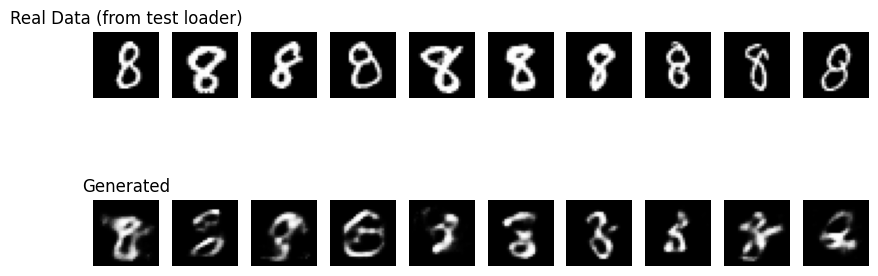

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def evaluate_model(model, data_loader, C=10, display_hyperparameters=False, hyperparams=None):
    """
    Évalue un modèle VAE sur un jeu de données en calculant la perte moyenne.

    :param model: Le modèle VAE à évaluer.
    :param data_loader: DataLoader fournissant les données d'évaluation.
    :param C: Nombre de classes pour la vectorisation one-hot (par défaut 10 pour MNIST).
    :param display_hyperparameters: Booléen pour indiquer si les hyperparamètres doivent être affichés.
    :param hyperparams: Un dictionnaire des hyperparamètres utilisés pour l'entraînement du modèle (facultatif).
    """
    model.eval()  # Mettre le modèle en mode d'évaluation
    total_loss = 0

    with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
        for x, labels in data_loader:
            x = x.view(x.size(0), -1)
            y = F.one_hot(labels, C).float()  # Convertir les étiquettes en vecteurs one-hot

            # Passer les données à travers le modèle
            mu, sigma, z, x_prime = model(x, y, False)

            # Calculer la perte de reconstruction
            loss = vae_loss(x_prime, x, mu, sigma)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader.dataset)
    print('Evaluation completed :')
    print(f'Average Loss: {avg_loss:.4f}')

    # Afficher les hyperparamètres si demandé
    if display_hyperparameters and hyperparams:
        print("Hyperparameters:")
        for key, value in hyperparams.items():
            print(f"{key}: {value}")
    print()
    return avg_loss




def generate_conditioned_samples(model, latent_dim, num_samples, condition_idx, real_data_loader):
    """
    Génère et affiche des échantillons conditionnés à partir du modèle cVAE entraîné et les compare
    avec les données réelles correspondantes.

    :param model: Le modèle cVAE entraîné.
    :param latent_dim: La taille de l'espace latent.
    :param num_samples: Le nombre d'échantillons à générer.
    :param condition_idx: L'index de la condition (ex. 0 pour le chiffre "0" dans MNIST).
    :param real_data_loader: DataLoader des données réelles de MNIST pour la comparaison.
    :return: Un tensor contenant les échantillons générés et affichage de la comparaison.
    """
    model.eval()  # Passer le modèle en mode évaluation

    with torch.no_grad():  # Pas besoin de calculer les gradients pour la génération
        # Créer des conditions one-hot pour la génération
        condition = torch.eye(10)[condition_idx].repeat(num_samples, 1)  # 10 pour le nombre total de classes dans MNIST

        # Échantillonner l'espace latent
        z = torch.randn(num_samples, latent_dim)

        # Générer des données à partir de z et condition
        generated_data = model.decode(z, condition).view(num_samples, 28, 28)  # Reshape output to image dimensions

        # Itérer sur le DataLoader pour obtenir un lot de données réelles
        for real_samples, labels in real_data_loader:
            # Filtrer les données réelles pour ne garder que celles correspondant à condition_idx
            mask = (labels == condition_idx)
            selected_real_samples = real_samples[mask]
            if selected_real_samples.size(0) >= num_samples:  # Assurez-vous d'avoir suffisamment d'échantillons
                selected_real_samples = selected_real_samples[:num_samples]
                break

        # Afficher les données réelles et générées pour comparaison
        fig, axes = plt.subplots(2, num_samples, figsize=(10, 4))
        axes[0, 0].set_title("Real Data (from test loader)")
        axes[1, 0].set_title("Generated")

        for i in range(num_samples):
            # Afficher les échantillons réels
            axes[0, i].imshow(selected_real_samples[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')

            # Afficher les échantillons générés
            axes[1, i].imshow(generated_data[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')

        plt.show()

    return generated_data  # Retourner les données générées




# Évaluation
# Utilisation de la fonction:
hyperparams = {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 20, 'beta': 0.02}
evaluate_model(model, test_loader, C=10, display_hyperparameters=True, hyperparams=hyperparams)

# Utilisation de la fonction pour générer des données
# Par exemple, générer 10 instances du chiffre "2"
generated_images = generate_conditioned_samples(model, latent_size, 10, 8, test_loader)
